In [134]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from Kernels import get_gaussianRBF
from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from KernelTools import get_kernel_block_ops,eval_k,diagpart
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results    
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 12
})
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

from Kernels import log1pexp,inv_log1pexp
import pysindy as ps
from pysindy.feature_library import FourierLibrary, CustomLibrary

In [135]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
# from scipy.io import loadmat
# from sklearn.metrics import mean_squared_error
# from scipy.integrate import solve_ivp

## Use `SINDy` differentiation package to get derivatives

In [136]:
k = get_gaussianRBF(0.2)
# t domain: (-1,1)
tau = jnp.linspace(-1,1,30)
dt = float(tau[1] - tau[0])
# x domain: (-1,1)
ex = jnp.linspace(-1,1,20)
q = jax.vmap(k,in_axes=(0,None))(tau.reshape(-1,1),0.)
# u values
Q = jnp.tile(q,20).reshape(20,30)

TAU, EX = jnp.meshgrid(tau,ex)
# (t,x) pairs
pairs = np.vstack([TAU.ravel(), EX.ravel()]).T
# u(t,x)
Q = Q.flatten()

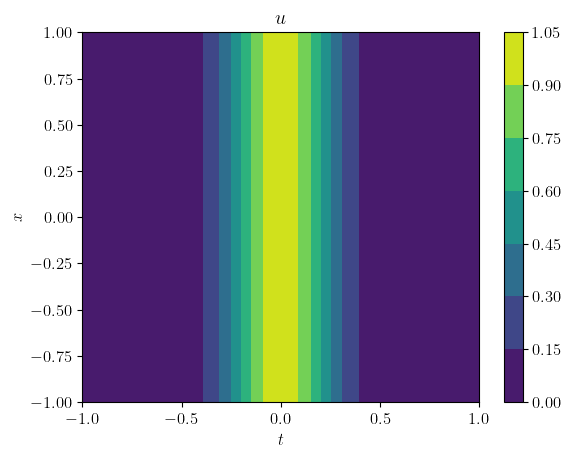

In [137]:
plt.tricontourf(*pairs.T,Q)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'$u$')
plt.colorbar()
plt.show()

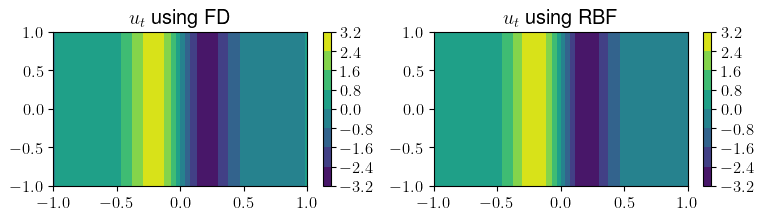

In [138]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (9,2))

# Compute derivative using FD
Q_dot_FD = ps.FiniteDifference(axis=1)._differentiate(Q.reshape(20,30), t=dt) # Finite differences (local)

axs[0].set_title('$u_t$ using FD')
axs0 = axs[0].tricontourf(*pairs.T,Q_dot_FD.flatten())
plt.colorbar(axs0, ax = axs[0])

# Compute derivative using RBF
diff_method = ps.SINDyDerivative(kind="kernel", sigma=0.2, lmbd=1e-8, kernel="rbf")
Q_dot_kernel = diff_method._differentiate(np.array(Q),pairs[:,0])

axs[1].set_title('$u_t$ using RBF')
axs1 = axs[1].tricontourf(*pairs.T,Q_dot_kernel)
plt.colorbar(axs1, ax = axs[1])

plt.show()

## Generate Burgers data

In [139]:
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0


kappa = 0.001
alpha = 5.


u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

  0%|          | 0/10099 [00:00<?, ?it/s]

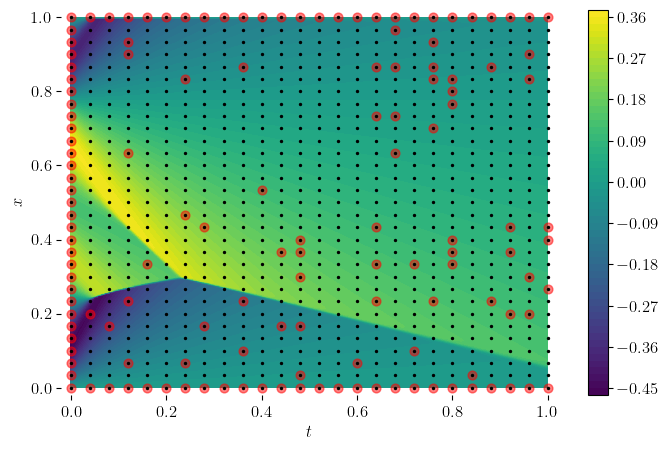

In [140]:
num_grid_x = 31
num_grid_t = 26
tx_int,tx_bdy = build_tx_grid([0,1],[0,1],num_grid_t,num_grid_x)

tx_all,tx_obs = setup_problem_data(
    tx_int,
    tx_bdy,
    60,
    jax.random.PRNGKey(55),
    times_to_observe = (0,)
)
# # Order in time tx_all
# tx_all = tx_all[tx_all[:,0].argsort()]
# # Order in time tx_obs
# tx_obs = tx_obs[tx_obs[:,0].argsort()]

u_true = u_true_function(tx_all)
u_obs = u_true_function(tx_obs)

num_fine_grid = 300
initial_time = 0
final_time = 1
t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

u_fine = u_true_function(tx_fine)

def plot_input_data(
    obs_points,
    all_points,
    func_to_plot,
    fine_grid,
    xlabel = r'$t$',
    ylabel = r'$x$',
    include_collocation = True
):
    plt.figure(figsize=(8,5))

    x_bounds = jnp.min(fine_grid[:,0]),jnp.max(fine_grid[:,0])
    y_bounds = jnp.min(fine_grid[:,1]),jnp.max(fine_grid[:,1])
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],func_to_plot(fine_grid),75)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_bounds[0] - 0.02,x_bounds[1] + 0.02)
    plt.ylim(y_bounds[0] - 0.02,y_bounds[1] + 0.02)
    plt.scatter(obs_points[:,0],obs_points[:,1],c='red', s = 40, alpha = 0.5,label = "Function Value Observed")
    if include_collocation is True:
        plt.scatter(all_points[:,0],all_points[:,1],c='black',s = 2,label = "Collocation Point")
    #plt.figlegend(loc = 'upper center')


plot_input_data(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


# plt.savefig("burgers_shock_data.svg")

##  `SINDy` using uniform grid of size $26 \times 31$

In [141]:
t = jnp.linspace(0,1,26)
x = jnp.linspace(0,1,31)
dt = float(t[1] - t[0])
u = u_true.reshape(31,26)
# Reshape u
u = u.reshape(len(x), len(t), 1)
# SINDy
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    #function_library=ps.PolynomialLibrary(degree=2,include_bias=False), 
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

In [142]:
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

STLSQ model: 
(u)' = 0.008 u_11 + 4.172 uu_1 + 0.105 uuu_11


## `SINDY` using 1.5 step flavor

Given data $u(Y)$. Get $\hat u$ and using autodiff $\hat u_t$, $\hat u_{x}$, and $\hat u_{xx}$

In [144]:
# Using obs build the following functions

u_operators = (eval_k,)
feature_operators = (eval_k,dt_k,dx_k,dxx_k)

def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)

k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))

# print(1/(jnp.sqrt(ML_lengthscales)))

u_model = CholInducedRKHS(
    tx_obs,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params = u_model.get_fitted_params(tx_obs,u_obs)

S = (
    (u_model.evaluate_operators(feature_operators,tx_all,u_params))
    .reshape(
            len(tx_all), 
            len(feature_operators),
            order = 'F'
        )
)

U_t = S[:,1]
UU_x = jnp.multiply(S[:,0],S[:,2])
U_xx = S[:,3]

Theta = jnp.vstack([UU_x, U_xx]).T

If $Y^*$ denotes the collocation grid. Compute $\hat u (Y^*)$, $\hat u_t(Y^*)$, $\hat u_{x}(Y^*)$, and $\hat u_{xx}(Y^*)$

Form the linear system 
$$
\hat u_t(Y^*) = [\hat u(Y^*)\hat u_x(Y^*) \quad \hat u_{xx}(Y^*)] \xi
$$
and find $\xi$ using Sequentially thresholded least squares algorithm (STLSQ)

In [145]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    # Initial guess: Least-squares
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0]

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coeffs.
        Xi[smallinds]=0 # and threshold
        for ind in range(n): # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,
                biginds],dXdt[:,ind],rcond=None)[0]
        return Xi

In [146]:
res = sparsifyDynamics(Theta,U_t.reshape(-1,1),lamb = 1e-8, n = 1)
print(f'SINDy recovered equation: u_t = {round(res[0][0],4)}uu_x + {round(res[1][0],4)}u_xx')

SINDy recovered equation: u_t = 1.272uu_x + 0.0066u_xx


Solve the found Burgers equation from SINDy

In [147]:
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0


kappa = res[1][0]
alpha = res[0][0]


u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

  0%|          | 0/10099 [00:00<?, ?it/s]

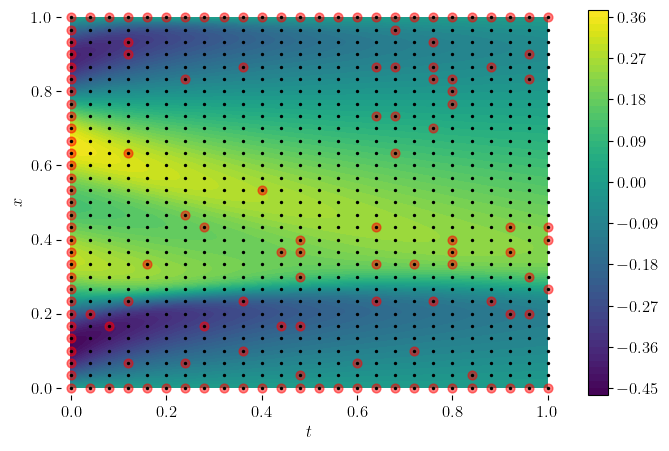

In [148]:
num_grid_x = 31
num_grid_t = 26
tx_int,tx_bdy = build_tx_grid([0,1],[0,1],num_grid_t,num_grid_x)

tx_all,tx_obs = setup_problem_data(
    tx_int,
    tx_bdy,
    60,
    jax.random.PRNGKey(55),
    times_to_observe = (0,)
)
# # Order in time tx_all
# tx_all = tx_all[tx_all[:,0].argsort()]
# # Order in time tx_obs
# tx_obs = tx_obs[tx_obs[:,0].argsort()]

u_true = u_true_function(tx_all)
u_obs = u_true_function(tx_obs)

num_fine_grid = 300
initial_time = 0
final_time = 1
t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

u_fine = u_true_function(tx_fine)

def plot_input_data(
    obs_points,
    all_points,
    func_to_plot,
    fine_grid,
    xlabel = r'$t$',
    ylabel = r'$x$',
    include_collocation = True
):
    plt.figure(figsize=(8,5))

    x_bounds = jnp.min(fine_grid[:,0]),jnp.max(fine_grid[:,0])
    y_bounds = jnp.min(fine_grid[:,1]),jnp.max(fine_grid[:,1])
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],func_to_plot(fine_grid),75)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_bounds[0] - 0.02,x_bounds[1] + 0.02)
    plt.ylim(y_bounds[0] - 0.02,y_bounds[1] + 0.02)
    plt.scatter(obs_points[:,0],obs_points[:,1],c='red', s = 40, alpha = 0.5,label = "Function Value Observed")
    if include_collocation is True:
        plt.scatter(all_points[:,0],all_points[:,1],c='black',s = 2,label = "Collocation Point")
    #plt.figlegend(loc = 'upper center')


plot_input_data(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


# plt.savefig("burgers_shock_data.svg")